# Representation Learning
Homework-2

## Imports

### Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as pimg
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D
import random
import os
import gzip
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow.keras.layers import Dense,Conv2D, Conv2DTranspose, Flatten, Input, Reshape
from tensorflow.keras.models import Model

from IPython.display import display, Math, Latex, HTML
from IPython import display as disp
display(HTML("<style>.container { width:100% !important; }</style>"))

### Reading Data

In [2]:
f = gzip.open('Dataset/train-images-idx3-ubyte.gz','r')
f.read(16)
Data = np.frombuffer(f.read(), dtype=np.uint8).astype(np.float32)
Data = Data.reshape(-1, 28*28)/255.0

## Multilayer Perceptron Model

Building a Multilayer Perceptron Model.

---

**Specifications:**
1. **Input Nodes:** L (Changes Dynamically with Input of the Model).
2. **Hidden Layers:** 1
3. **Nodes in Hidden Layer:** M
4. **Output Nodes:** K (Changes dynamically with Output of the Model).
5. **Activation Function($\sigma$):** Sigmoid
6. **Loss Function:** SE(Square Error) or KLD(KL Divergence) or SparseLoss(SE + KLD)
7. Optimizer: Batch Gradient Descent

---

**Forward Propagation:**

\begin{align}
    A_1 = XW_1 + b_1 \\
    H_1 = \sigma(A_1) \\
    A_2 = XH_1 + b_2 \\
    \hat{Y} = H_2 = \sigma(A_2)
\end{align}

**Loss Function:**
\begin{align}
    L = \frac{1}{k}\|Y - \hat{Y}\|^2 
\end{align}

**Activation Function:**
\begin{align}
    \sigma(x) = \frac{1}{1 + e^{-x}}
\end{align}

**Back Propagation:**

**Note:**
1. Assuming BatchSize = k
2. The term $dP = \frac{\partial{L}}{\partial{P}}$ i.e Partial Deravative of Loss($L$) wrt Parameter($P$)

\begin{align}
    dH_2 = \frac{2}{k}(H_2 - Y)\\
    dA_2 = dH_2 \odot \sigma(A_2)(1-\sigma(A_2)) = dH_2 \odot H_2(1-H_2) \\
    dW_2 = H_1^T A_2 \\
    db_2 = \sum dA_2 \\
    \\
    dH_1 = dA_2W_2^T\\
    dA_1 = dH_1 \odot \sigma(A_1)(1-\sigma(A_1)) = dH_1 \odot H_1(1-H_1) \\
    dW_1 = X^T A_1 \\
    db_1 = \sum dA_1
\end{align}

**Update Parameters:**

\begin{align}
    W_2 = W_2 - \alpha(dW_2)\\
    b_2 = b_2 - \alpha(db_2)\\
    W_1 = W_1 - \alpha(dW_1)\\
    b_1 = b_1 - \alpha(db_1)
\end{align}

In [3]:
class MLP:
    def __init__(self,M,LossFunction):
        # Model Specifications
        self.L = None
        self.M = M
        self.K = None
        self.N = None
        self.LossFunction = LossFunction
        self.LossData = []
        
        # Dataset
        self.X = None
        
        
    def PrintParameters(self):
        # Print all Parameters
        print ("self.W1", self.W1.shape)
        print ("self.b1", self.b1.shape)
        print ("self.A1", self.A1.shape)
        print ("self.H1", self.H1.shape)

        print ("self.W2", self.W2.shape)
        print ("self.b2", self.b2.shape)
        print ("self.A2", self.A2.shape)
        print ("self.H2", self.H2.shape)

        print ("self.dW1", self.dW1.shape)
        print ("self.db1", self.db1.shape)
        print ("self.dA1", self.dA1.shape)
        print ("self.dH1", self.dH1.shape)

        print ("self.dW2", self.dW2.shape)
        print ("self.db2", self.db2.shape)
        print ("self.dA2", self.dA2.shape)
        print ("self.dH2", self.dH2.shape)

        print ("-------------------------")


    def InitializeParameters(self):
        # Model Parameters
        """
        Considering no.of Hidden Layers = 1
        """
        self.W1 = np.random.randn(self.L,self.M)
        self.b1 = np.random.randn(1,self.M)
        
        self.W2 = np.random.randn(self.M,self.K)
        self.b2 = np.random.randn(1,self.K)


    def ActivationFunction(self,I):
        # Sigmoid Activation Function
        return np.divide(1.0,(1.0 + np.exp(-I)))
    

    def GradientActivation(self,I):
        # Gradient of Sigmoid Activation where 'I' denotes Output of Sigmoid.
        return I * (1.0 - I)
    

    def Loss(self, Y_pred, Y, _lambda = 0.1, p=0.01):
        # Loss Function
        if self.LossFunction == "SE":
            return (np.sum(np.square(Y-Y_pred))/Y.shape[0])
        elif self.LossFunction == "SparseLoss":
            Z = np.mean(self.H1,axis=0)
            return (np.sum(np.square(Y-Y_pred))/Y.shape[0]) + _lambda*(np.sum(p*np.log(p) + (1-p)*np.log(1-p) - p*np.log(1e-6 + Z) - (1-p)*np.log(1e-6 + 1-Z)))

        
    def ForwardPropagation(self,X,ReturnHiddenLayer=False):
        # Forward Propagation
        self.A1 = np.matmul(X,self.W1) + self.b1
        self.H1 = self.ActivationFunction(self.A1)
        self.A2 = np.matmul(self.H1,self.W2) + self.b2
        self.H2 = self.ActivationFunction(self.A2)
        
        if ReturnHiddenLayer == False:
            return self.H2
        else:
            return self.H2, self.H1
    
    
    def BackPropagation(self, X, Y, _lambda = 0.1, p=0.01):
        # Back Propagation
        if self.LossFunction == "SE":
            self.dH2 = 2*(self.H2 - Y)/Y.shape[0]
        elif self.LossFunction == "SparseLoss":
            self.dH2 = 2*(self.H2 - Y)/Y.shape[0]
            
        self.dA2 = np.multiply(self.dH2, self.GradientActivation(self.H2))
        self.dW2 = np.matmul(self.H1.T, self.dA2)
        self.db2 = np.sum(self.dA2, axis=0).reshape(1,-1)
        
        self.dH1 = np.matmul(self.dA2,self.W2.T) 
        if self.LossFunction == "SparseLoss":
            Z = np.mean(self.H1,axis=0)
            self.dH1 += (_lambda/Y.shape[0])*(-p*np.divide(1,1e-6 + Z) + (1-p)*np.divide(1,1e-6 + 1-Z))
        self.dA1 = np.multiply(self.dH1, self.GradientActivation(self.H1))
        self.dW1 = np.matmul(X.T, self.dA1)
        self.db1 = np.sum(self.dA1, axis=0).reshape(1,-1)
            
        
    def UpdateParameters(self):
        # Updating Parameters using Gradient Descent
        self.W1 -= (self.lr * self.dW1)
        self.b1 -= (self.lr * self.db1)

        self.W2 -= (self.lr * self.dW2)
        self.b2 -= (self.lr * self.db2)  
        

    def fit(self, X, Y, Epochs, BatchSize, lr, LoadWeightsPath=None, SaveWeightsPath = None, SaveWeights=True, LoadWeights=True):
        # Training Model
        self.X = X
        if len(Y.shape) == 1:
            self.Y = np.expand_dims(Y,axis=-1)
        else:
            self.Y = Y
            
        self.N = self.X.shape[0]
        self.L = self.X.shape[1]
        self.K = self.Y.shape[1]
        
        self.lr = lr
        
        if LoadWeights == False or LoadWeightsPath == None:
            self.InitializeParameters()
        else:
            self.W1 = np.load(LoadWeightsPath + "/W1.npy")
            self.b1 = np.load(LoadWeightsPath + "/b1.npy")
            self.W2 = np.load(LoadWeightsPath + "/W2.npy")
            self.b2 = np.load(LoadWeightsPath + "/b2.npy")
        
        for i in range(Epochs):
            Steps = self.N//BatchSize
            l = []
            for j in range(Steps):
                
                if BatchSize == 1:
                    I = np.expand_dims(self.X[j],axis=0)
                    O = np.expand_dims(self.Y[j],axis=0)

                else:
                    I = self.X[j*BatchSize:(j+1)*BatchSize]
                    O = self.Y[j*BatchSize:(j+1)*BatchSize]

                self.ForwardPropagation(I)
                l.append(self.Loss(self.H2, O))
                self.BackPropagation(I,O)
                self.UpdateParameters()
            
            print ("Epoch: %-*s  Loss: %-*s" % (6,i+1,24,np.mean(l)))
            print () 
            self.LossData.append(np.mean(l))

        if SaveWeightsPath != None and SaveWeights == True:
            np.save(SaveWeightsPath + "/W1.npy", self.W1)
            np.save(SaveWeightsPath + "/b1.npy", self.b1)
            np.save(SaveWeightsPath + "/W2.npy", self.W2)
            np.save(SaveWeightsPath + "/b2.npy", self.b2)


    def PlotLoss(self):
        # Plotting Loss
        plt.figure(figsize=(10,10))
        plt.style.use('dark_background')
        plt.plot(self.LossData,'yellow')
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Loss Function")
        plt.grid()
        plt.show()

    
    def loadWeights(self,LoadWeightsPath):
        # Load Weights of Model
        self.W1 = np.load(LoadWeightsPath + "/W1.npy")
        self.b1 = np.load(LoadWeightsPath + "/b1.npy")
        self.W2 = np.load(LoadWeightsPath + "/W2.npy")
        self.b2 = np.load(LoadWeightsPath + "/b2.npy")

    def predict(self,X,ReturnHiddenLayer=False):
        # Predicting from Data
        return self.ForwardPropagation(X,ReturnHiddenLayer)

## Boolean Operations

Training a MLP for the following Binary Operations:
1. XOR
2. AND
3. OR

### Generating Samples

Generating Samples for for Training the Model.

In [4]:
def GenerateSamples(Operation,N):
    """
    Operation: Boolean Operation
    N: No.of Samples
    """
    X = np.round(np.random.uniform(0,1,(N,2)))
    
    if Operation == 'AND':
        y = np.logical_and(np.round(X[:,0]),np.round(X[:,1])).astype(int)
        
    if Operation == 'OR':
        y = np.logical_or(np.round(X[:,0]),np.round(X[:,1])).astype(int)
        
    if Operation == 'XOR':
        y = np.logical_xor(np.round(X[:,0]),np.round(X[:,1])).astype(int)
        
    return X,y

### AND Operation

Creating Model and Generating Data

In [5]:
AND_Model = MLP(2,"SE")
X_AND, y_AND = GenerateSamples("AND",400)

Training  Model and Plotting Loss

Epoch: 1       Loss: 0.1566336271967658      

Epoch: 2       Loss: 0.05088705662665914     

Epoch: 3       Loss: 0.012822092992159213    

Epoch: 4       Loss: 0.005951498734074003    

Epoch: 5       Loss: 0.0036941922186600152   

Epoch: 6       Loss: 0.002627728595351906    

Epoch: 7       Loss: 0.0020189099397953793   

Epoch: 8       Loss: 0.001629414968886082    

Epoch: 9       Loss: 0.0013605998967874706   

Epoch: 10      Loss: 0.0011647699966236      

Epoch: 11      Loss: 0.0010162210818087348   

Epoch: 12      Loss: 0.000899944329256492    

Epoch: 13      Loss: 0.0008066186953759268   

Epoch: 14      Loss: 0.000730165182081349    

Epoch: 15      Loss: 0.0006664582097010951   



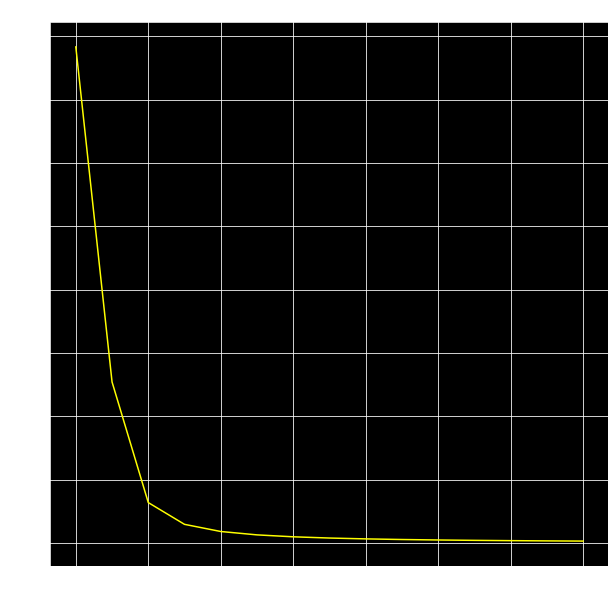

In [6]:
AND_Model.fit(X_AND,y_AND,15,2,0.9)
AND_Model.PlotLoss()

### OR Operation

Creating Model and Generating Data

In [7]:
OR_Model = MLP(2,"SE")
X_OR, y_OR = GenerateSamples("OR",400)

Training  Model and Plotting Loss

Epoch: 1       Loss: 0.1727201084787717      

Epoch: 2       Loss: 0.04967040645631471     

Epoch: 3       Loss: 0.011000112887099766    

Epoch: 4       Loss: 0.0052596938254373836   

Epoch: 5       Loss: 0.0033309898736747735   

Epoch: 6       Loss: 0.002398730587504178    

Epoch: 7       Loss: 0.001858029285585721    

Epoch: 8       Loss: 0.0015081631707580308   

Epoch: 9       Loss: 0.0012646327830900654   

Epoch: 10      Loss: 0.001086041382850649    

Epoch: 11      Loss: 0.0009498466193446618   

Epoch: 12      Loss: 0.0008427751970455158   

Epoch: 13      Loss: 0.0007565264147359024   

Epoch: 14      Loss: 0.0006856547243505901   

Epoch: 15      Loss: 0.0006264456260513371   



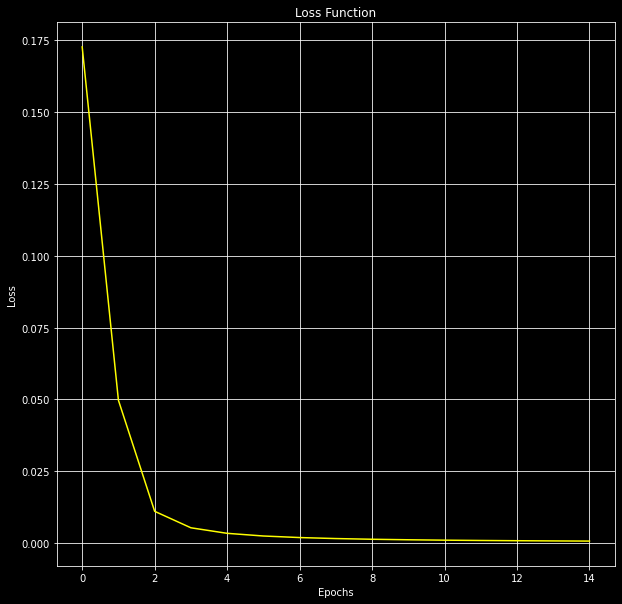

In [8]:
OR_Model.fit(X_OR,y_OR,15,2,0.9)
OR_Model.PlotLoss()

### XOR Operation

Creating Model and Generating Data

In [9]:
XOR_Model = MLP(2,"SE")
X_XOR, y_XOR = GenerateSamples("XOR",400)

Training  Model and Plotting Loss

Epoch: 1       Loss: 0.26385456366956045     

Epoch: 2       Loss: 0.24732339244395082     

Epoch: 3       Loss: 0.21481515566110734     

Epoch: 4       Loss: 0.1903856801765514      

Epoch: 5       Loss: 0.16708130872609966     

Epoch: 6       Loss: 0.10642909657801755     

Epoch: 7       Loss: 0.04367544692902484     

Epoch: 8       Loss: 0.021722715385120894    

Epoch: 9       Loss: 0.013665657449682964    

Epoch: 10      Loss: 0.009756726870116193    

Epoch: 11      Loss: 0.0075048307518632      

Epoch: 12      Loss: 0.006059194585067838    

Epoch: 13      Loss: 0.005060231778728704    

Epoch: 14      Loss: 0.004332261411994001    

Epoch: 15      Loss: 0.003780084578894201    

Epoch: 16      Loss: 0.003347955433745754    

Epoch: 17      Loss: 0.003001205002549231    

Epoch: 18      Loss: 0.002717209213769026    

Epoch: 19      Loss: 0.0024806114628358415   

Epoch: 20      Loss: 0.002280640639222624    



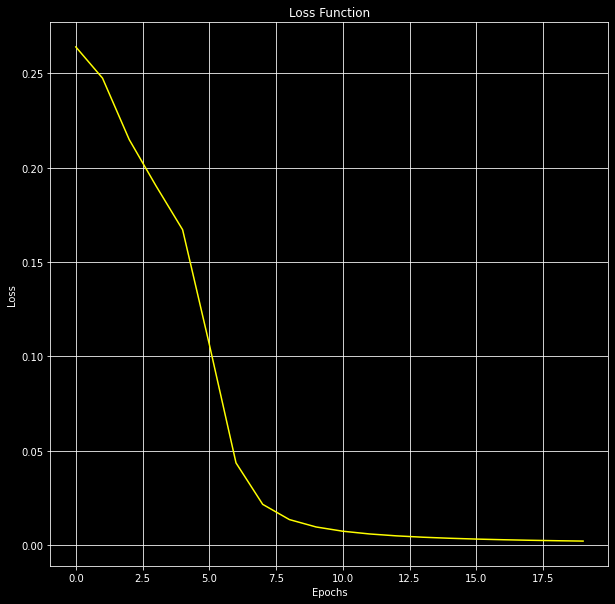

In [10]:
XOR_Model.fit(X_XOR,y_XOR,20,2,0.9)
XOR_Model.PlotLoss()

## Sparse Auto-Encoder



### Model Training

Creating and Training the a Sparse Auto-Encoder

**Training Specifications:**
1. Hidden Nodes(M): 960
2. p = 0.01
3. Learning-Rate = 0.1
4. Epochs = 20, BatchSize = 4

Loss Function of Sparse Auto-Encoder for a BatchSize of **k** is

\begin{align}
    L = \frac{1}{k}\Bigg(\sum_{i=1}^{k} ||x_i - \hat{x}_i ||^2\Bigg) + \lambda\sum_{i=1}^{M} \mathrm{KL}\left(p \| \bar{z}_{i}\right)
\end{align}
where
\begin{align}
    \mathrm{KL}\left(p \| \bar{z}_{i}\right) = p \log \frac{p}{\bar{z}_{i}}+(1-p) \log \frac{1-p}{1-\bar{z}_{i}}\\
    \bar{z}_{i} = \frac{1}{k}\sum_{i=1}^{k}z_{i}
\end{align}

One of the step in Back Propagation changes to

\begin{align}
    dH_1 = dA_2W_2^T + \frac{\lambda}{k}\bigg(-\frac{p}{\bar{z}_{i}}+\frac{1-p}{1-\bar{z}_{i}}\bigg)
\end{align}

---

Note: Weights of Model are saved and uploaded in [GitHub](https://github.com/dks2000dks/IIT-Hyderabad-Semester-Courses/tree/master/EE5601/HW2/Weights/SparseAE).

#### Initialising Model

In [11]:
SparseAE = MLP(960,"SparseLoss")

#### Training Model

Training the  Model and Saving Weights

In [ ]:
SparseAE.fit(Data,Data,20,4,0.1, SaveWeightsPath = "Weights/SparseAE", LoadWeightsPath = None)

Epoch: 1       Loss: 41.190731899595754      

Epoch: 2       Loss: 22.8878144952091        

Epoch: 3       Loss: 18.916948009106903      

Epoch: 4       Loss: 16.563820705356264      

Epoch: 5       Loss: 14.752407276811757      

Epoch: 6       Loss: 13.28339255716466       

Epoch: 7       Loss: 12.105232787557217      

Epoch: 8       Loss: 11.1536243064106        

Epoch: 9       Loss: 10.320651272881543      

Epoch: 10      Loss: 9.539464325053416       

Epoch: 11      Loss: 8.897027174966224       

Epoch: 12      Loss: 8.341108573671871       

Epoch: 13      Loss: 7.852119437372769       

Epoch: 14      Loss: 7.401985130422402       

Epoch: 15      Loss: 7.030864514549494       

Epoch: 16      Loss: 6.708220185145986       

Epoch: 17      Loss: 6.425011736483528       

Epoch: 18      Loss: 6.175104575889199       

Epoch: 19      Loss: 5.9501026612028385      

Epoch: 20      Loss: 5.737311536526973       



#### Plotting Loss

Plotting Loss for Epoch

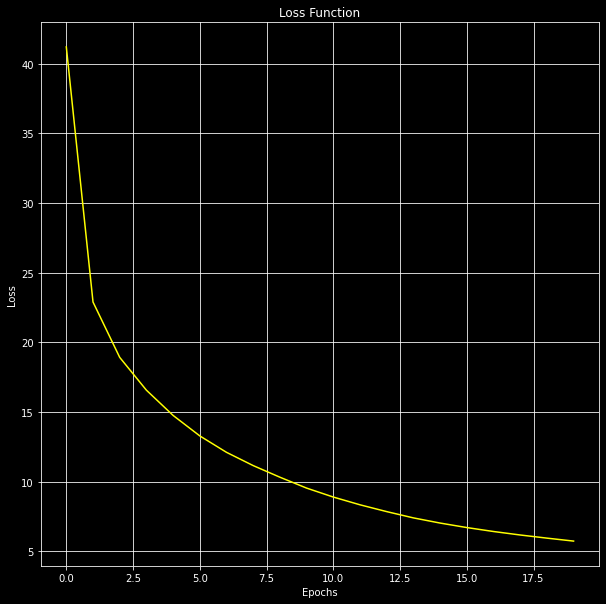

In [ ]:
SparseAE.PlotLoss()

#### Results

Generating Results for Random Images of Dataset.

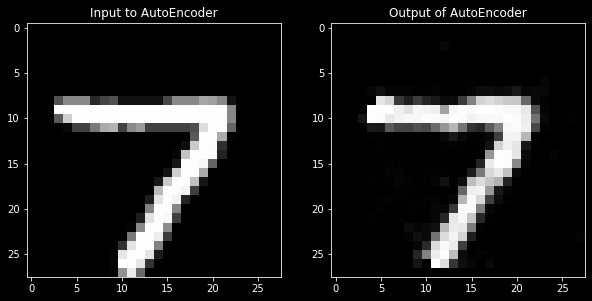

In [12]:
SparseAE.loadWeights("Weights/SparseAE")

i = np.random.randint(0,Data.shape[0]-1)
I = Data[i].reshape(28,28)
O,H = SparseAE.predict(Data[i],True)
O = O.reshape(28,28)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.title('Input to AutoEncoder')
plt.imshow(I,cmap='gray')
plt.subplot(1,2,2)
plt.title('Output of AutoEncoder')
plt.imshow(O,cmap='gray')
plt.show()

#### Sparse Vector

Sparse AutoEncoder has a Sparse Hidden Layer.

In [13]:
print ("Sparse Latent Vector:\n", H)
print ("Error in Sparsity:", np.linalg.norm(H - np.round(H)))

Sparse Latent Vector:
 [[1.63313835e-04 3.31443094e-04 4.91593605e-02 3.06358671e-03
  4.42570580e-03 2.11554017e-02 3.49086079e-03 5.94377358e-04
  1.47484103e-02 4.86134755e-05 1.20802206e-02 5.46700853e-05
  6.47405641e-01 1.27352817e-03 1.82834334e-05 2.06743156e-03
  3.01989416e-05 3.41345590e-05 8.70439409e-03 2.57516572e-04
  4.34870878e-03 8.47202630e-03 4.67696439e-03 3.90598733e-04
  3.34523692e-03 1.31734997e-02 8.20581956e-03 4.18328486e-06
  3.15674523e-04 5.59377738e-01 5.57891840e-03 1.07994762e-04
  2.81939811e-03 1.09012317e-02 2.45653543e-03 1.85231748e-04
  2.72668073e-04 1.95739004e-04 4.44691846e-06 1.90764388e-04
  6.27383628e-03 2.41727249e-07 3.54499107e-04 1.13964110e-03
  4.48493923e-03 7.99095875e-02 8.82737386e-04 8.17026619e-04
  4.19596602e-03 6.85523998e-03 5.18933316e-03 2.98631486e-04
  6.57189196e-02 2.80432333e-04 8.32305455e-04 1.21540700e-03
  3.61559022e-03 1.07005492e-04 9.87242626e-05 5.33966038e-04
  9.60712834e-05 6.01905868e-03 9.91391981e-04 

## Variational AutoEncoder

**Assumptions:**
1. Encoder outputs mean($\mu$) and logarithm of diagonal values of CoVariance matrix($\sum$).
2. Considering only diagonal elements of CoVariaance matrix. And also assuming encoder outputs only diagonal elements.
3. From online sources, it is found that it is a common practice to use "$\log(\sigma)$" values rather than "$\sigma$" as "$\log$" can map numerically very small numbers to large spaces. (Source: [StackExchange](https://stats.stackexchange.com/questions/353220/why-in-variational-auto-encoder-gaussian-variational-family-we-model-log-sig))
4. $f(z)$ is the output of VAE.

---


Inorder for VAE to perform good, we need to maximize,
\begin{align}
    \log(p(x)) - KL\left[Q(z|x) || p(z|x) \right] = \mathop{\mathbb{E}}_{z \sim Q(z|x)}\log(p(x|z)) - KL\left[Q(z|x) || p(z) \right]
\end{align}
where,
\begin{align}
    p(x|z) = \mathcal{N}(x;f(z),\sigma^2I)
\end{align}
i.e, as Loss should be minimised,
\begin{align}
    Loss = KL\left[Q(z|x) || p(z) \right] - \mathop{\mathbb{E}}_{z \sim Q(z|x)}\log(p(x|z))\\
    KL\left[Q(z|x) || p(z) \right] = \frac{1}{2}\left[Tr\left(\sum(x)\right) + \mu(x)^T\mu(x) - d - \log ||\sum(x)||\right]\\
    \mathop{\mathbb{E}}_{z \sim Q(z|x)}\log(p(x|z)) = K - ||x - f(z)||^2 \\
    Loss =  \frac{1}{2}\left[Tr\left(\sum(x)\right) + \mu(x)^T\mu(x) - d - \log ||\sum(x)||\right]\\ + ||x - f(z)||^2 \text{ (Ignoring K as it is a constant)}
\end{align}

By considering Assumptions,
\begin{align}
    L = \frac{1}{k}\sum_{i=1}^{k} \Bigg(||x_i - f(z_i)||^2 + \frac{1}{2}\left[\sum_{j=1}^{d}e^{\log\sigma_j^2} + \mu(x_i)^T\mu(x_i) - \sum_{j=1}^{d}\log\sigma_j^2 - d \right]\Bigg)
\end{align}

where **d** is no.of Latent Dimensions.


**Note:**
KL divergence Loss term increases when the Probability Distribution generated by the Encoder diverges from the $\mathcal{N}(0,I)$ Standard Normal Distribution. Effectively, this means that the Neural Network is Regularized to learn an Encoder that produces a Probability Distribution with $\mu \approx 0$ and $\sum \approx I$, “pushing” the probability distributions and hence the sampled $X$'s close together.

---

**Note:**
Weights of Model are saved and uploaded in [GitHub](https://github.com/dks2000dks/IIT-Hyderabad-Semester-Courses/tree/master/EE5601/HW2/Weights/VAE).



### ImageData Preparation

Preparing Image Data for Training the Model.

In [14]:
ImageData = Data.reshape(-1,28,28,1)

### Creating Model

Creating a Variational AutoEncoder with Reparametrisation

In [15]:
tf.keras.backend.clear_session()

class SamplingLayer(tf.keras.layers.Layer):
    # Creating a Sampling Layer as a part of Reparametrisation
    def call(self, inputs):
        mu, log_var = inputs
        batchSize = tf.shape(mu)[0]
        latentDims = tf.shape(mu)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batchSize, latentDims))
        return mu + tf.multiply(epsilon,tf.exp(log_var))

class VAE(tf.keras.Model):
    # Variational AutoEncoder with Reparametrisation
    def __init__(self, LatentDims):
        super(VAE, self).__init__()
        self.LatentDims = LatentDims
        self.Encoder = self.EncoderModel()
        tf.keras.utils.plot_model(self.Encoder,"Images/Encoder.png",show_shapes=True,show_layer_names=True,expand_nested=True)
        self.Decoder = self.DecoderModel()
        tf.keras.utils.plot_model(self.Decoder,"Images/Decoder.png",show_shapes=True,show_layer_names=True,expand_nested=True)

    def EncoderModel(self):
        # Encoder Model
        EI = Input(shape=(28,28,1))
        x = Conv2D(32, 3, activation="relu", strides=2, padding="same")(EI)
        x = Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
        x = Flatten()(x)
        mu = Dense(self.LatentDims)(x)
        log_var = Dense(self.LatentDims)(x)
        latentData = SamplingLayer()([mu, log_var])

        return Model(inputs = EI, outputs=[mu,log_var,latentData], name="Encoder")

    def DecoderModel(self):
        # Decoder Model
        DI = Input(shape=(self.LatentDims,))
        x = Dense(7*7*64, activation="relu")(DI)
        x = Reshape((7,7,64))(x)
        x = Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
        x = Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
        DO = Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

        return Model(inputs = DI, outputs=DO, name="Decoder")

    def LossFunction(self,X,Xhat,mu,log_var):
        # Loss = Reconstruction Loss + KL-Divergence
        BatchSize,LatentDims = mu.get_shape().as_list()
        ReconstructionLoss = tf.math.reduce_mean(tf.reduce_sum(tf.square(X-Xhat), axis=(1,2,3)))
        KLD = tf.math.reduce_mean(0.5 * (tf.math.reduce_sum(tf.square(mu) + tf.exp(log_var) - log_var, axis=1) - LatentDims))
        return ReconstructionLoss, KLD

    def train_step(self,data):
        # Training Model
        with tf.GradientTape() as tape:
            mu,log_var,latentData = self.Encoder(data)
            datahat = self.Decoder(latentData)

            ReconstructionLoss, KLD = self.LossFunction(data,datahat,mu,log_var)
            Loss = ReconstructionLoss + KLD

        grads = tape.gradient(Loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        return {
            "Loss": Loss,
            "Reconstruction Loss": ReconstructionLoss,
            "KL-Divergence": KLD,
                }

    def predict(self,X):
        # Prediction for an Input
        mu,sigma,latentData = self.Encoder(X)
        return self.Decoder.predict(latentData)

### Model Training

Training Specifications
1. **Epochs:** 40
2. **Latent Dimensions:** 16
3. **BatchSize:** 32
4. **Optimizer:** Adam



In [16]:
LatentDims = 16
Epochs = 40
BatchSize = 32

#### Initialising Model

In [17]:
vae = VAE(LatentDims)
vae.compile(optimizer=tf.keras.optimizers.Adam())

#### Training Model
Training the  Model and Saving Weights

In [ ]:
history = vae.fit(ImageData, epochs=Epochs, batch_size=BatchSize)
vae.save_weights("Weights/VAE/")

Epoch 1/40
1875/1875 [==============================] - 6s 3ms/step - Loss: 30.7264 - Reconstruction Loss: 22.4140 - KL-Divergence: 8.3124
Epoch 2/40
1875/1875 [==============================] - 6s 3ms/step - Loss: 22.7233 - Reconstruction Loss: 12.5850 - KL-Divergence: 10.1383
Epoch 3/40
1875/1875 [==============================] - 6s 3ms/step - Loss: 21.9460 - Reconstruction Loss: 11.7209 - KL-Divergence: 10.2251
Epoch 4/40
1875/1875 [==============================] - 6s 3ms/step - Loss: 21.4897 - Reconstruction Loss: 11.2594 - KL-Divergence: 10.2303
Epoch 5/40
1875/1875 [==============================] - 6s 3ms/step - Loss: 21.1872 - Reconstruction Loss: 10.9628 - KL-Divergence: 10.2244
Epoch 6/40
1875/1875 [==============================] - 6s 3ms/step - Loss: 20.9881 - Reconstruction Loss: 10.7567 - KL-Divergence: 10.2314
Epoch 7/40
1875/1875 [==============================] - 6s 3ms/step - Loss: 20.7947 - Reconstruction Loss: 10.5792 - KL-Divergence: 10.2155
Epoch 8/40
1875/1875 

#### Results

Generating Results for Random Images of Dataset.

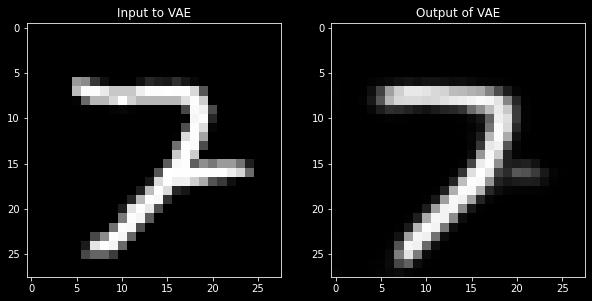

In [18]:
vae.load_weights("Weights/VAE/")
i = np.random.randint(0,Data.shape[0]-1)
I = ImageData[i,:,:,0]
O = vae.predict(I.reshape(1,28,28,1))
O = O.reshape(28,28)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.title('Input to VAE')
plt.imshow(I,cmap='gray')
plt.subplot(1,2,2)
plt.title('Output of VAE')
plt.imshow(O,cmap='gray')
plt.show()